In [57]:
from alpha_vantage.timeseries import TimeSeries
import pandas as pd
import numpy as np
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import math, random
from datetime import datetime
import datetime as dt
import preprocessor as p
import re
from sklearn.linear_model import LinearRegression
from textblob import TextBlob

In [58]:
pip install -r requirements.txt

  Preparing metadata (setup.py) ... done


In [59]:
pip install twelvedata

In [60]:
import warnings
warnings.filterwarnings("ignore")
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

In [61]:
from twelvedata import TDClient
import pandas as pd

def get_historical(quote):
    td = TDClient(apikey="a8a4987f3ed043be86eac53635dbbace")

    try:
        print(f"Fetching data for {quote} from Twelve Data...")

        ts = td.time_series(
            symbol=quote,
            interval="1day",
            outputsize=500,
            order="asc"
        )

        df = ts.as_pandas()

        if df.empty or 'close' not in df.columns:
            print(f"No valid data returned for {quote}.")
            return

        # Reset index (datetime)
        df.reset_index(inplace=True)

        # Rename only if the column exists
        col_map = {
            'datetime': 'Date',
            'open': 'Open',
            'high': 'High',
            'low': 'Low',
            'close': 'Close',
            'volume': 'Volume'
        }

        df.rename(columns={k: v for k, v in col_map.items() if k in df.columns}, inplace=True)

        # Create 'Adj Close' as copy of 'Close'
        df['Adj Close'] = df['Close']

        # Reorder columns (safely)
        expected_cols = ['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']
        df = df[[col for col in expected_cols if col in df.columns]]

        df.to_csv(f"{quote}.csv", index=False)
        print(f"Saved {quote}.csv successfully.")

    except Exception as e:
        print(f"Error fetching data for {quote}: {e}")


In [62]:
#************* LSTM SECTION **********************

def LSTM_ALGO(df):
    #Split data into training set and test set
    dataset_train=df.iloc[0:int(0.8*len(df)),:]
    dataset_test=df.iloc[int(0.8*len(df)):,:]
    ############# NOTE #################
    #TO PREDICT STOCK PRICES OF NEXT N DAYS, STORE PREVIOUS N DAYS IN MEMORY WHILE TRAINING
    # HERE N=7
    ###dataset_train=pd.read_csv('Google_Stock_Price_Train.csv')
    training_set=df.iloc[:,4:5].values# 1:2, to store as numpy array else Series obj will be stored
    #select cols using above manner to select as float64 type, view in var explorer

    #Feature Scaling
    from sklearn.preprocessing import MinMaxScaler
    sc=MinMaxScaler(feature_range=(0,1))#Scaled values btween 0,1
    training_set_scaled=sc.fit_transform(training_set)
    #In scaling, fit_transform for training, transform for test

    #Creating data stucture with 7 timesteps and 1 output.
    #7 timesteps meaning storing trends from 7 days before current day to predict 1 next output
    X_train=[]#memory with 7 days from day i
    y_train=[]#day i
    for i in range(7,len(training_set_scaled)):
        X_train.append(training_set_scaled[i-7:i,0])
        y_train.append(training_set_scaled[i,0])
    #Convert list to numpy arrays
    X_train=np.array(X_train)
    y_train=np.array(y_train)
    X_forecast=np.array(X_train[-1,1:])
    X_forecast=np.append(X_forecast,y_train[-1])
    #Reshaping: Adding 3rd dimension
    X_train=np.reshape(X_train, (X_train.shape[0],X_train.shape[1],1))#.shape 0=row,1=col
    X_forecast=np.reshape(X_forecast, (1,X_forecast.shape[0],1))
    #For X_train=np.reshape(no. of rows/samples, timesteps, no. of cols/features)

    #Building RNN
    from keras.models import Sequential
    from keras.layers import Dense
    from keras.layers import Dropout
    from keras.layers import LSTM

    #Initialise RNN
    regressor=Sequential()

    #Add first LSTM layer
    regressor.add(LSTM(units=50,return_sequences=True,input_shape=(X_train.shape[1],1)))
    #units=no. of neurons in layer
    #input_shape=(timesteps,no. of cols/features)
    #return_seq=True for sending recc memory. For last layer, retrun_seq=False since end of the line
    regressor.add(Dropout(0.1))

    #Add 2nd LSTM layer
    regressor.add(LSTM(units=50,return_sequences=True))
    regressor.add(Dropout(0.1))

    #Add 3rd LSTM layer
    regressor.add(LSTM(units=50,return_sequences=True))
    regressor.add(Dropout(0.1))

    #Add 4th LSTM layer
    regressor.add(LSTM(units=50))
    regressor.add(Dropout(0.1))

    #Add o/p layer
    regressor.add(Dense(units=1))

    #Compile
    regressor.compile(optimizer='adam',loss='mean_squared_error')

    #Training
    regressor.fit(X_train,y_train,epochs=25,batch_size=32 )
    #For lstm, batch_size=power of 2

    #Testing
    ###dataset_test=pd.read_csv('Google_Stock_Price_Test.csv')
    real_stock_price=dataset_test.iloc[:,4:5].values

    #To predict, we need stock prices of 7 days before the test set
    #So combine train and test set to get the entire data set
    dataset_total=pd.concat((dataset_train['Close'],dataset_test['Close']),axis=0)
    testing_set=dataset_total[ len(dataset_total) -len(dataset_test) -7: ].values
    testing_set=testing_set.reshape(-1,1)
    #-1=till last row, (-1,1)=>(80,1). otherwise only (80,0)

    #Feature scaling
    testing_set=sc.transform(testing_set)

    #Create data structure
    X_test=[]
    for i in range(7,len(testing_set)):
        X_test.append(testing_set[i-7:i,0])
        #Convert list to numpy arrays
    X_test=np.array(X_test)

    #Reshaping: Adding 3rd dimension
    X_test=np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))

    #Testing Prediction
    predicted_stock_price=regressor.predict(X_test)

    #Getting original prices back from scaled values
    predicted_stock_price=sc.inverse_transform(predicted_stock_price)
    fig = plt.figure(figsize=(7.2,4.8),dpi=65)
    plt.plot(real_stock_price,label='Actual Price')
    plt.plot(predicted_stock_price,label='Predicted Price')
    plt.legend(loc=4)

    #plt.savefig('static/LSTM.png')
    #plt.close(fig)


    error_lstm = math.sqrt(mean_squared_error(real_stock_price, predicted_stock_price))


    #Forecasting Prediction
    forecasted_stock_price=regressor.predict(X_forecast)

    #Getting original prices back from scaled values
    forecasted_stock_price=sc.inverse_transform(forecasted_stock_price)

    lstm_pred=forecasted_stock_price[0,0]
    print()
    print("##############################################################################")
    print("Tomorrow's ",quote," Closing Price Prediction by LSTM: ",lstm_pred)
    print("LSTM RMSE:",error_lstm)
    print("##############################################################################")
    return lstm_pred,error_lstm

In [63]:
#***************** LINEAR REGRESSION SECTION ******************
def LIN_REG_ALGO(df):
    #No of days to be forcasted in future
    forecast_out = int(7)
    #Price after n days
    df['Close after n days'] = df['Close'].shift(-forecast_out)
    #New df with only relevant data
    df_new=df[['Close','Close after n days']]

    #Structure data for train, test & forecast
    #lables of known data, discard last 35 rows
    y =np.array(df_new.iloc[:-forecast_out,-1])
    y=np.reshape(y, (-1,1))
    #all cols of known data except lables, discard last 35 rows
    X=np.array(df_new.iloc[:-forecast_out,0:-1])
    #Unknown, X to be forecasted
    X_to_be_forecasted=np.array(df_new.iloc[-forecast_out:,0:-1])

    #Traning, testing to plot graphs, check accuracy
    X_train=X[0:int(0.8*len(df)),:]
    X_test=X[int(0.8*len(df)):,:]
    y_train=y[0:int(0.8*len(df)),:]
    y_test=y[int(0.8*len(df)):,:]

    # Feature Scaling===Normalization
    from sklearn.preprocessing import StandardScaler
    sc = StandardScaler()
    X_train = sc.fit_transform(X_train)
    X_test = sc.transform(X_test)

    X_to_be_forecasted=sc.transform(X_to_be_forecasted)

    #Training
    clf = LinearRegression(n_jobs=-1)
    clf.fit(X_train, y_train)

    #Testing
    y_test_pred=clf.predict(X_test)
    y_test_pred=y_test_pred*(1.04)
    import matplotlib.pyplot as plt2
    fig = plt2.figure(figsize=(7.2,4.8),dpi=65)
    plt2.plot(y_test,label='Actual Price' )
    plt2.plot(y_test_pred,label='Predicted Price')

    plt2.legend(loc=4)

    #plt2.savefig('static/LR.png')
    #plt2.close(fig)

    error_lr = math.sqrt(mean_squared_error(y_test, y_test_pred))


    #Forecasting
    forecast_set = clf.predict(X_to_be_forecasted)
    forecast_set=forecast_set*(1.04)
    mean=forecast_set.mean()
    lr_pred=forecast_set[0,0]
    print()
    print("##############################################################################")
    print("Tomorrow's ",quote," Closing Price Prediction by Linear Regression: ",lr_pred)
    print("Linear Regression RMSE:",error_lr)
    print("##############################################################################")
    return df, lr_pred, forecast_set, mean, error_lr

In [64]:
quote = input("Enter stock ticker symbol: ")

Enter stock ticker symbol: AAPL


In [65]:
get_historical(quote)
#************** PREPROCESSING ***********************
df = pd.read_csv(''+quote+'.csv')
print("##############################################################################")
print("Today's",quote,"Stock Data: ")
today_stock=df.iloc[-1:]
print(today_stock)
print("##############################################################################")
df = df.dropna()
code_list=[]
for i in range(0,len(df)):
    code_list.append(quote)
df2=pd.DataFrame(code_list,columns=['Code'])
df2 = pd.concat([df2, df], axis=1)
df=df2

Fetching data for AAPL from Twelve Data...
Saved AAPL.csv successfully.
##############################################################################
Today's AAPL Stock Data: 
           Date   Open       High        Low   Close  Adj Close    Volume
499  2025-05-09  199.0  200.53999  197.53999  198.53     198.53  36415700
##############################################################################


Epoch 1/25
16/16 ━━━━━━━━━━━━━━━━━━━━ 8s 16ms/step - loss: 0.1375
Epoch 2/25
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0387
Epoch 3/25
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0165
Epoch 4/25
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0093
Epoch 5/25
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0088
Epoch 6/25
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0092
Epoch 7/25
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0090
Epoch 8/25
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0079
Epoch 9/25
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0086
Epoch 10/25
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0084
Epoch 11/25
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0086
Epoch 12/25
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0084
Epoch 13/25
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0074
Epoch 14/25
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0088
Epoch 15/25
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0077
Epoc

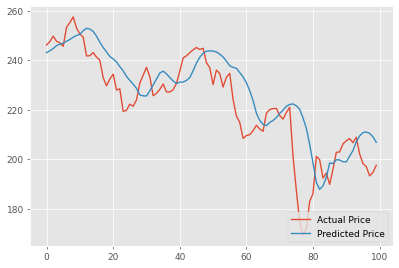

In [66]:
lstm_pred, error_lstm=LSTM_ALGO(df)


##############################################################################
Tomorrow's  AAPL  Closing Price Prediction by Linear Regression:  223.09449959040023
Linear Regression RMSE: 20.198407343338445
##############################################################################


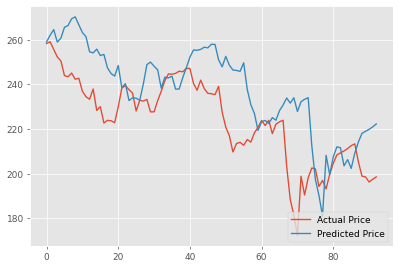

In [67]:
 df, lr_pred, forecast_set,mean,error_lr=LIN_REG_ALGO(df)

In [68]:
import kagglehub
import pandas as pd
import matplotlib.pyplot as plt
from textblob import TextBlob
import re
import nltk

nltk.download('punkt')

# Download Sentiment140 dataset using KaggleHub
path = kagglehub.dataset_download("kazanova/sentiment140")
print("Path to dataset files:", path)

# Load Sentiment140 dataset into a pandas DataFrame
sentiment140_file = f"{path}/training.1600000.processed.noemoticon.csv"
df = pd.read_csv(sentiment140_file, encoding="ISO-8859-1", header=None)

# Renaming columns for better understanding
df.columns = ['polarity', 'id', 'date', 'query', 'user', 'text']

# Remove any unnecessary columns
df = df[['polarity', 'text']]

# Map the sentiment polarity: 0 -> Negative, 2 -> Neutral, 4 -> Positive
df['sentiment'] = df['polarity'].map({0: 'Negative', 4: 'Positive'})

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Path to dataset files: /kaggle/input/sentiment140


In [70]:
def perform_sentiment_analysis(df, num_of_tweets=300):
    # Limiting the dataset to the first num_of_tweets tweets
    df = df.head(num_of_tweets)

    # Initialize counters for sentiment categories
    pos = 0
    neg = 0
    neutral = 0
    global_polarity = 0

    # List to store tweet texts and their polarity
    tweet_list = []
    tw_list = []

    # Iterate over the tweets and analyze sentiment
    for index, row in df.iterrows():
        tweet = row['text']
        sentiment = row['sentiment']
        blob = TextBlob(tweet)

        # Calculate the polarity of the tweet
        polarity = 0
        for sentence in blob.sentences:
            polarity += sentence.sentiment.polarity

        # Update sentiment counters
        if polarity > 0:
            pos += 1
        elif polarity < 0:
            neg += 1
        else:
            neutral += 1

        # Add tweet polarity to global polarity score
        global_polarity += polarity

        # Store tweet for future reference
        tw_list.append(tweet)
        tweet_list.append((tweet, polarity))

    # Calculate average polarity of the tweets
    if len(tweet_list) > 0:
        global_polarity /= len(tweet_list)

    print(f"Positive Tweets: {pos}, Negative Tweets: {neg}, Neutral Tweets: {neutral}")

    # Plotting the sentiment distribution
    labels = ['Positive', 'Negative', 'Neutral']
    sizes = [pos, neg, neutral]
    explode = (0.1, 0, 0)  # Exploding the positive slice for better visibility
    fig, ax1 = plt.subplots(figsize=(7.2, 4.8), dpi=65)
    ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%', startangle=90)
    ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle
    plt.tight_layout()
    plt.show()

    # Determine overall polarity
    if global_polarity > 0:
        print("Tweets Polarity: Overall Positive")
        tw_pol = "Overall Positive"
    else:
        print("Tweets Polarity: Overall Negative")
        tw_pol = "Overall Negative"

    return global_polarity, tw_list, tw_pol, pos, neg, neutral

In [71]:
#---------RECOMMENDATIONS BASED ON TWEETS & Models-------------------
def recommending(df, global_polarity, today_stock, mean, symbol):
    # Check if the current stock price is below the average
    if today_stock.iloc[-1]['Close'] < mean:
        # If the sentiment is positive (global_polarity > 0), suggest a "BUY"
        if global_polarity > 0:
            idea = "RISE"
            decision = "BUY"
            print()
            print("##############################################################################")
            print(f"According to the ML Predictions and Sentiment Analysis of {symbol} stock, a {idea} is expected => {decision}")
        # If the sentiment is negative or neutral (global_polarity <= 0), suggest a "SELL"
        elif global_polarity <= 0:
            idea = "FALL"
            decision = "SELL"
            print()
            print("##############################################################################")
            print(f"According to the ML Predictions and Sentiment Analysis of {symbol} stock, a {idea} is expected => {decision}")
    else:
        # If the stock price is above the average, suggest a "SELL"
        idea = "FALL"
        decision = "SELL"
        print()
        print("##############################################################################")
        print(f"According to the ML Predictions and Sentiment Analysis of {symbol} stock, a {idea} is expected => {decision}")

    return idea, decision


Positive Tweets: 90, Negative Tweets: 104, Neutral Tweets: 106


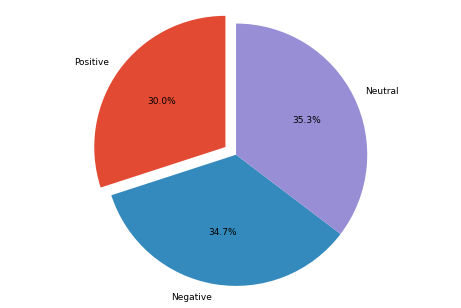

Tweets Polarity: Overall Negative


In [75]:
import pandas as pd
from textblob import TextBlob
import matplotlib.pyplot as plt

# Load Sentiment140 data
df = pd.read_csv("/kaggle/input/sentiment140/training.1600000.processed.noemoticon.csv", encoding='latin-1', header=None)
df.columns = ['target', 'ids', 'date', 'flag', 'user', 'text']


df['sentiment'] = df['target'].map({0: 'negative', 2: 'neutral', 4: 'positive'})

keywords = ["AAPL", "Apple"]
stock_df = df[df['text'].str.contains('|'.join(keywords), case=False, na=False)]



global_polarity, tw_list, tw_pol, pos, neg, neutral = perform_sentiment_analysis(stock_df)


In [76]:
symbol = "AAPL"
today_stock = pd.DataFrame({'Close': [150]})  # Example stock data
mean = 140  # Example mean price
global_polarity = 0.15  # Example global polarity from sentiment analysis

idea, decision = recommending(df, global_polarity, today_stock, mean, symbol)


##############################################################################
According to the ML Predictions and Sentiment Analysis of AAPL stock, a FALL is expected => SELL


In [69]:
!python -m textblob.download_corpora

[nltk_data] Downloading package brown to /root/nltk_data...
[nltk_data]   Package brown is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package conll2000 to /root/nltk_data...
[nltk_data]   Package conll2000 is already up-to-date!
[nltk_data] Downloading package movie_reviews to /root/nltk_data...
[nltk_data]   Package movie_reviews is already up-to-date!
Finished.
